In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
DATA_PATH = 'processed_data'
COMMODITIES = ['Maize', 'Wheat', 'Oats', 'Soybeans']
CONTRACTS = ['March', 'May', 'July', 'September']
COMMODITIES_LOCS = {'Maize': 1, 'Oats': 2, 'Soybeans': 3, 'Wheat': 4}
TEST_SIZE = 0.1

## Time Series Forecasting - Comodity Contracts Price Prediction

In [3]:
WINDOW_SIZE = 100
LR = 0.001
NUM_EPOCHS = 50

Each dataset is a long time series (6.5 years), and we split it using windows to a lot of shorter time series, which will allow us to train a model efficiently.

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=WINDOW_SIZE):
        self.data = data
        self.window_size = window_size
    
    def __len__(self):
        return len(self.data) - self.window_size
    
    def __getitem__(self, idx):
        # return (X, y) pair
        return self.data[idx:idx+self.window_size], self.data[idx+self.window_size]

We experminted with 2 sequential models: Basic RNN and LSTM. In both of them we add a Dense layer to the output of the RNN/LSTM layer to get the final prediction. We also tried to add a Dropout layer to the model to prevent overfitting but it just made the model worse so we removed it.

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_layers=1, extra_fc_layers=0):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)
        if extra_fc_layers > 0:
            self.extra_fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(extra_fc_layers)])
            self.activation = nn.ReLU()
        else:
            self.extra_fc_layers = None
            self.activation = None
    
    def forward(self, x):
        out, _ = self.rnn(x)
        if self.extra_fc_layers is not None:
            for layer in self.extra_fc_layers:
                out = layer(out)
                out = self.activation(out)
        out = self.fc(out[:, -1, :])
        return out

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_layers=1, extra_fc_layers=0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 4)
        if extra_fc_layers > 0:
            self.extra_fc_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(extra_fc_layers)])
            self.activation = nn.ReLU()
        else:
            self.extra_fc_layers = None
            self.activation = None
    
    def forward(self, x):
        out, _ = self.lstm(x)
        if self.extra_fc_layers is not None:
            for layer in self.extra_fc_layers:
                out = layer(out)
                out = self.activation(out)
        out = self.fc(out[:, -1, :])
        return out

We used Mean Squared Error as the loss function, but in the end we compared the results using Root Mean Squared Error, in order to keep the same scale as the target variable.

In [7]:
def test_model(model, test_loader, criterion, scaler=None, loc=1, calc_rmse=True):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            rel_targets = targets[:, (loc-1)*4:loc*4]
            loss = criterion(outputs, rel_targets)
            total_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(rel_targets)
    
    all_outputs = torch.cat(all_outputs).numpy()
    all_targets = torch.cat(all_targets).numpy()
    if scaler is not None:
        padded_outputs = np.zeros((all_outputs.shape[0], inputs.shape[2]))
        padded_outputs[:, (loc-1)*4:loc*4] = all_outputs
        all_outputs = scaler.inverse_transform(padded_outputs)[:, (loc-1)*4:loc*4]
        padded_targets = np.zeros((all_targets.shape[0], inputs.shape[2]))
        padded_targets[:, (loc-1)*4:loc*4] = all_targets
        all_targets = scaler.inverse_transform(padded_targets)[:, (loc-1)*4:loc*4]
    if calc_rmse:
        rmse = root_mean_squared_error(all_targets, all_outputs)
        return total_loss / len(test_loader), rmse
    else:
        return total_loss / len(test_loader)

For each commodaty dataset, we did a train, validation and test split of 80%, 10% and 10% respectively. We trained the model on the train set and validated it on the validation set in order to tune the hyperparameters and choose the best model from the training process. In addition, we scaled the data using the StandardScaler class from the sklearn library, as we found that it improved the model's performance dramatically (without scaling the data, the models were not able to learn anything and they kept predicting constant values).

In [8]:
def train_model(model, train_loader, test_loader, criterion, optimizer, loc=1, num_epochs=NUM_EPOCHS):
    train_losses = []
    test_losses = []
    calc_losses = test_loader is not None
    best_loss = np.inf
    best_model = None
    for _ in tqdm(range(num_epochs)):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.float(), targets.float()
            outputs = model(inputs)
            rel_targets = targets[:, (loc - 1)*4:loc * 4]
            loss = criterion(outputs, rel_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if calc_losses:
            train_loss = test_model(model, train_loader, criterion, loc=loc, calc_rmse=False)
            train_losses.append(train_loss)
            test_loss = test_model(model, test_loader, criterion, loc=loc, calc_rmse=False)
            test_losses.append(test_loss)
            if test_loss < best_loss:
                best_loss = test_loss
                best_model = model.state_dict()
    
    if calc_losses:
        return train_losses, test_losses, best_model
    return

In [9]:
def create_commodity_dataloaders(commodity, test_size=TEST_SIZE, scale=True): 
    base_df = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
    base_df.drop(columns=['Date'], inplace=True)
    base_data = torch.tensor(base_df.values).float()
    if scale:
        scaler = StandardScaler()
        base_data = scaler.fit_transform(base_data)
    test_segment = - int(test_size * len(base_df))

    # add window to val and test data
    train_data = base_data[:2 * test_segment]
    val_data = base_data[2 * test_segment - WINDOW_SIZE: test_segment]
    test_data = base_data[test_segment - WINDOW_SIZE:]

    train_dataset = TimeSeriesDataset(train_data)
    val_dataset = TimeSeriesDataset(val_data)
    test_dataset = TimeSeriesDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    if scale:
        return train_loader, val_loader, test_loader, scaler
    return train_loader, val_loader, test_loader

In [10]:
def tune_sequential_model(commodity, model_name, hidden_size, num_layers, 
                          extra_fc_layers, lr=LR, num_epochs=NUM_EPOCHS):
    train_loader_commodity, val_loader_commodity, _, scaler = create_commodity_dataloaders(commodity)
    if model_name == 'RNN':
        model = RNNModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
    elif model_name == 'LSTM':
        model = LSTMModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
    else:
        print('Invalid model')
        return
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, best_model = \
        train_model(model, train_loader_commodity, val_loader_commodity,
                    criterion, optimizer, num_epochs=num_epochs)
    model.load_state_dict(best_model)

    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss for {}'.format(commodity))
    plt.legend()
    plt.show()
    
    print(f'{commodity} Best Model Validation RMSE: '
                  f'{test_model(model, val_loader_commodity, criterion, scaler=scaler, calc_rmse=True)[1]:.4f}')

We got the following results for the RNN model:

| Model | Hidden Size | Num Layers | Extra FC Layers | Maize Validation RMSE | Wheat Validation RMSE | Oats Validation RMSE | Soybeans Validation RMSE | Average Validation RMSE |
|-------|-------------|------------|----------------|-----------------------|----------------------|---------------------|-------------------------|-------------------------|
| RNN   | 8           | 1          | 0              | 10.7188               | 14.0548              | 10.2458             | 17.4528                 | 13.1175                 |
| RNN   | 8           | 1          | 1              | 11.2155               | 16.3037              | 10.6244             | 18.6453                 | 14.1972                 |
| RNN   | 8           | 2          | 0              | 9.7380                | 35.3674              | 12.4609             | 17.9751                 | 18.1354                 |
| RNN   | 8           | 2          | 1              | 14.1709               | 18.4373              | 14.5248             | 20.3804                 | 16.6283                 |
| RNN   | 16          | 1          | 0              | 8.8238                | 15.3083              | 11.9983             | 15.1521                 | 12.3206                 |
| RNN   | 16          | 1          | 1              | 10.8211               | 15.3411              | 11.9633             | 17.5214                 | 13.9117                 |
| RNN   | 16          | 2          | 0              | 9.3474                | 15.3041              | 13.6066             | 15.5626                 | 13.7052                 |
| RNN   | 16          | 2          | 1              | 10.4300               | 13.2384              | 14.2504             | 18.5511                 | 14.1175                 |
| RNN   | 32          | 1          | 0              | 9.5212                | 13.4151              | 11.6792             | 17.3192                 | 12.7337                 |
| RNN   | 32          | 1          | 1              | 9.7920                | 16.4402              | 15.8505             | 16.1402                 | 14.5557                 |
| RNN   | 32          | 2          | 0              | 10.0828               | 14.0610              | 12.7982             | 16.0668                 | 13.2520                 |
| RNN   | 32          | 2          | 1              | 10.4300               | 13.2384              | 14.2504             | 18.5511                 | 14.3674                 |


It can be seen that the best model is the one with 16 hidden units, 1 layer and no extra fully connected layers. The average validation RMSE for this model is 12.3206.

In [11]:
RNN_HIDDEN_SIZE = 16
RNN_NUM_LAYERS = 1
RNN_EXTRA_FC_LAYERS = 0

We got the following results for the LSTM model:
| Model                            | Hidden Size | Num Layers | Extra FC Layers | Maize Validation RMSE | Wheat Validation RMSE | Oats Validation RMSE | Soybeans Validation RMSE | Average Validation RMSE |
|-|-|-|-|-|-|-|-|-|
| LSTM                             | 8           | 1          | 0              | 12.7971               | 14.2909              | 13.2626             | 18.3784                 | 14.6823                 |
| LSTM                             | 8           | 1          | 1              | 10.3391               | 20.9127              | 27.7830             | 18.4544                 | 19.8723                 |
| LSTM                             | 8           | 2          | 0              | 17.2849               | 18.6913              | 29.1445             | 19.5646                 | 21.6713                 |
| LSTM                             | 8           | 2          | 1              | 15.6158               | 28.9694              | 29.7757             | 18.2005                 | 23.1403                 |
| LSTM                             | 16          | 1          | 0              | 11.5493               | 19.1203              | 19.2684             | 17.6005                 | 16.8846                 |
| LSTM                             | 16          | 1          | 1              | 10.9558               | 19.1502              | 28.5749             | 17.2167                 | 18.9744                 |
| LSTM                             | 16          | 2          | 0              | 13.0831               | 19.2080              | 22.1270             | 17.0416                 | 17.8649                 |
| LSTM                             | 16          | 2          | 1              | 12.1573               | 17.0833              | 22.7135             | 17.5013                 | 17.3638                 |
| LSTM                             | 32          | 1          | 0              | 10.0584               | 15.1898              | 17.9758             | 17.2611                 | 15.1213                 |
| LSTM                             | 32          | 1          | 1              | 10.0820               | 13.8705              | 24.4978             | 16.9787                 | 16.8573                 |
| LSTM                             | 32          | 2          | 0              | 11.7069               | 15.1920              | 29.8667             | 18.2130                 | 18.7447                 |
| LSTM                             | 32          | 2          | 1              | 10.6982               | 15.5973              | 27.0322             | 16.8868                 | 17.0536                 |


It can be seen that the best model is the one with 32 hidden units, 1 layer and no extra fully connected layers. The average validation RMSE for this model is 15.1213. 

Notice that we got the same layers amount and extra FC layers amount as the best RNN model, but the hidden size is different. Notably, the best LSTM model has a higher average validation RMSE than the best RNN model, although the LSTM model has more parameters than the RNN model.

In [12]:
LSTM_HIDDEN_SIZE = 32
LSTM_NUM_LAYERS = 1
LSTM_EXTRA_FC_LAYERS = 0

In [13]:

def eval_sequential_model(commodities_lst=COMMODITIES, model_name='RNN', hidden_size=8, num_layers=1, 
                          extra_fc_layers=0, lr=LR, num_epochs=NUM_EPOCHS):
    torch.manual_seed(0)
    for i, commodity in enumerate(commodities_lst):
        train_loader_commodity, val_loader_commodity, test_loader_commodity, scaler = create_commodity_dataloaders(commodity)
        if model_name == 'RNN':
            model = RNNModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        elif model_name == 'LSTM':
            model = LSTMModel(input_size=6, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        else:
            print('Invalid model')
            return
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        _, _, best_model = train_model(model, train_loader_commodity, val_loader_commodity,
                                                            criterion, optimizer, num_epochs=num_epochs)
        model.load_state_dict(best_model)
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        axes = axes.flatten()
        model.eval()
        targets_lst = []
        outputs_lst = []
        with torch.no_grad():
            for inputs, targets in test_loader_commodity:
                inputs, targets = inputs.float(), targets.float()
                outputs = model(inputs)
                targets_lst.append(targets)
                outputs_lst.append(outputs)
        targets = torch.cat(targets_lst).numpy()
        outputs = torch.cat(outputs_lst).numpy()
        
        targets = scaler.inverse_transform(targets)[:, :4]
        
        padded_outputs = np.zeros((outputs.shape[0], inputs.shape[2]))
        padded_outputs[:, :4] = outputs
        outputs = scaler.inverse_transform(padded_outputs)[:, :4]
        
        for j in range(4):
            contract_name = CONTRACTS[j]
            days = list(range(1, len(targets) + 1))
            axes[j].plot(days, targets[:, j], label='Actual', color='blue')
            axes[j].plot(days, outputs[:, j], label='Predicted', color='orange')
            axes[j].set_title(f'{contract_name}', fontsize=14)
            axes[j].set_xlabel('Day in Test Set', fontsize=12)
            axes[j].set_ylabel('Contract Price', fontsize=12)
            axes[j].legend(fontsize=12)
            
        plt.tight_layout(h_pad=1.0, w_pad=2.0)
        fig.suptitle(f'{commodity} Prediction Mission - Test Predictions', fontsize=16, y=1.03)
        plt.show()
        
        _, rmse = test_model(model, test_loader_commodity, criterion, scaler=scaler, calc_rmse=True)
        print(f'{commodity} Final Model Test RMSE: {rmse:.4f}')
        if i < len(commodities_lst) - 1:
            print()

Finally, we trained each of the models one last time and then tested it on the test set.

100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


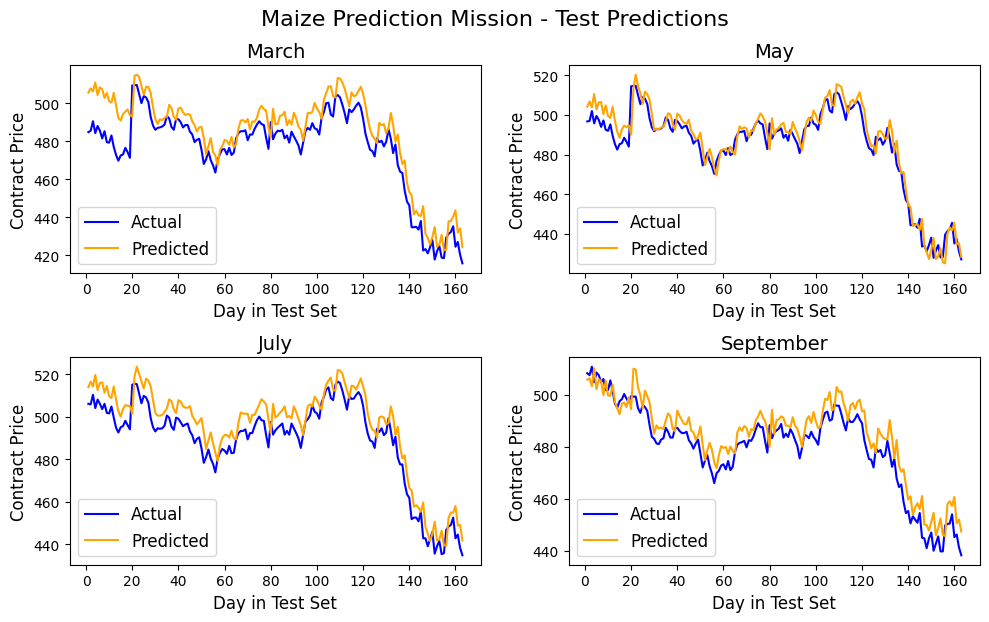

Maize Final Model Test RMSE: 8.1070



100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


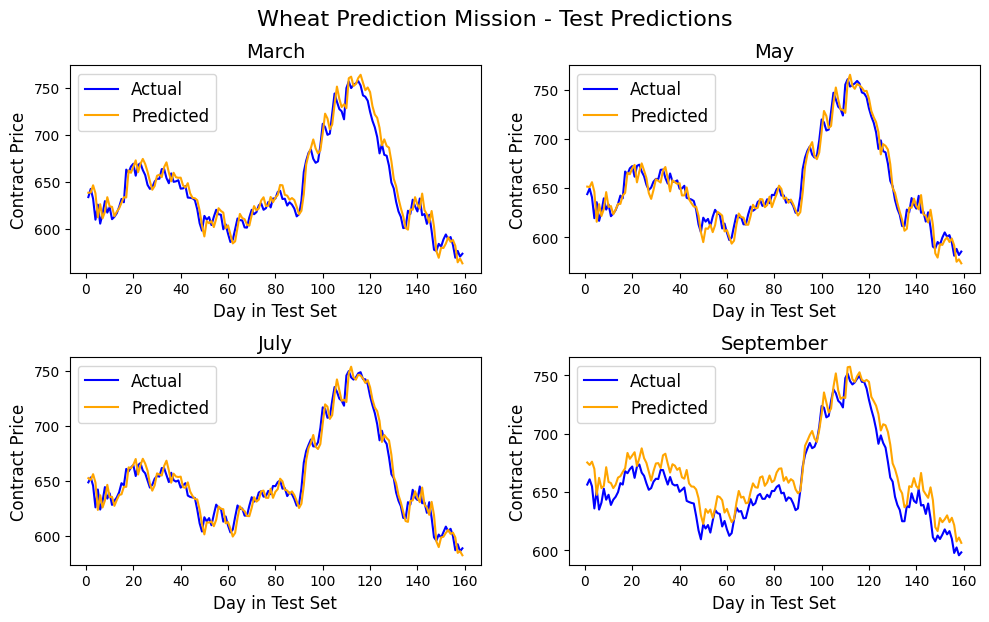

Wheat Final Model Test RMSE: 11.1297



100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


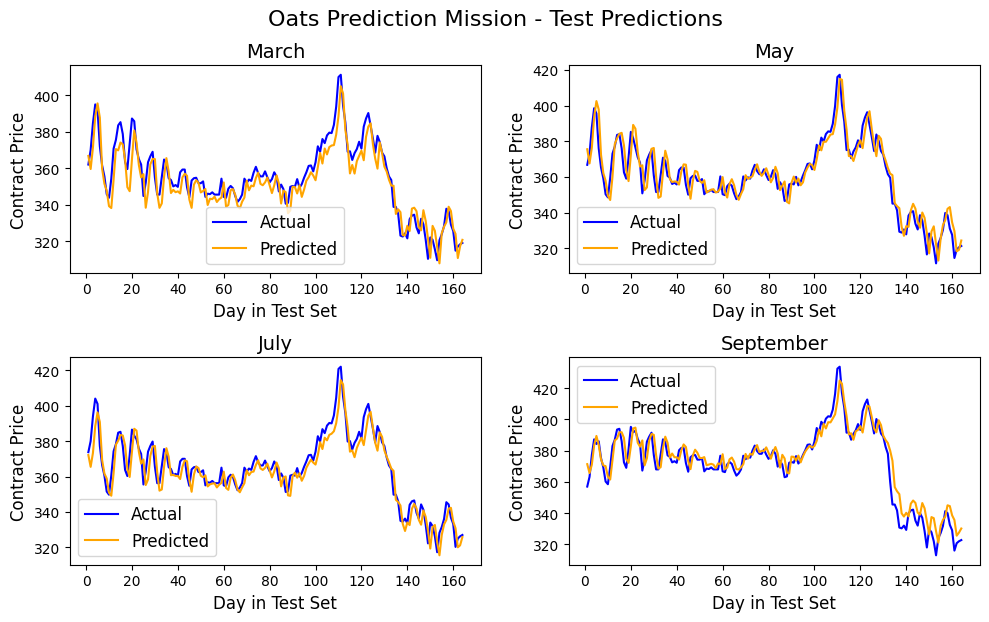

Oats Final Model Test RMSE: 7.4099



100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


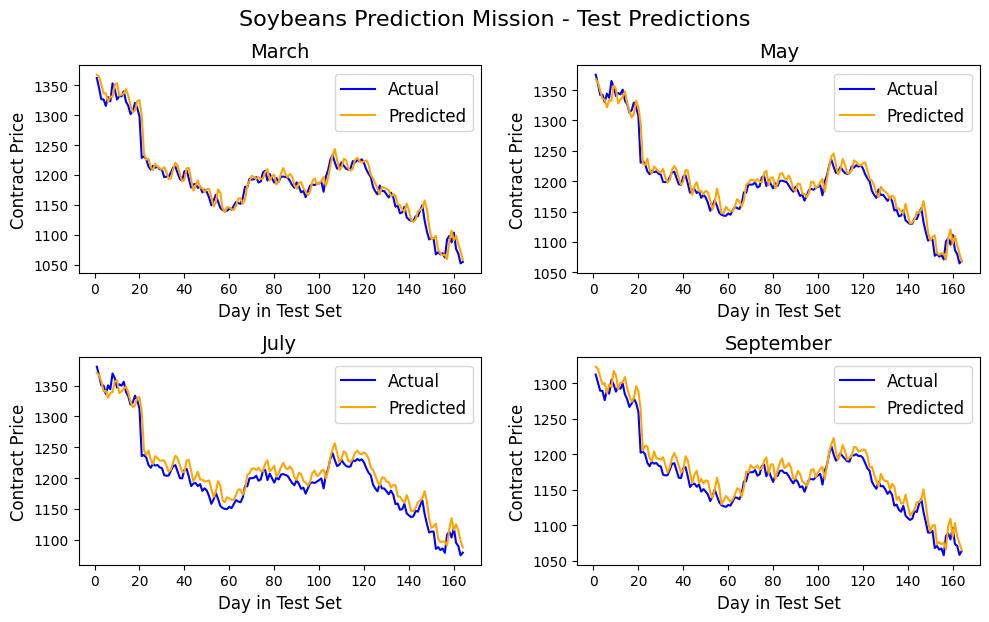

Soybeans Final Model Test RMSE: 14.7783


In [14]:
eval_sequential_model(model_name='RNN', hidden_size=RNN_HIDDEN_SIZE, num_layers=RNN_NUM_LAYERS, extra_fc_layers=RNN_EXTRA_FC_LAYERS, 
                      lr=LR, num_epochs=NUM_EPOCHS)

# FIX

Results summary - RNN model:
| Model | Hidden Size | Num Layers | Extra FC Layers | Maize Test RMSE | Wheat Test RMSE | Oats Test RMSE | Soybeans Test RMSE | Average Test RMSE |
|-------|-------------|------------|----------------|-----------------|-----------------|----------------|---------------------|-------------------|
| RNN   | 16          | 1          | 0              | 8.1070         | 11.1297         | 7.4099       | 14.7783          | 10.3562          |

100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


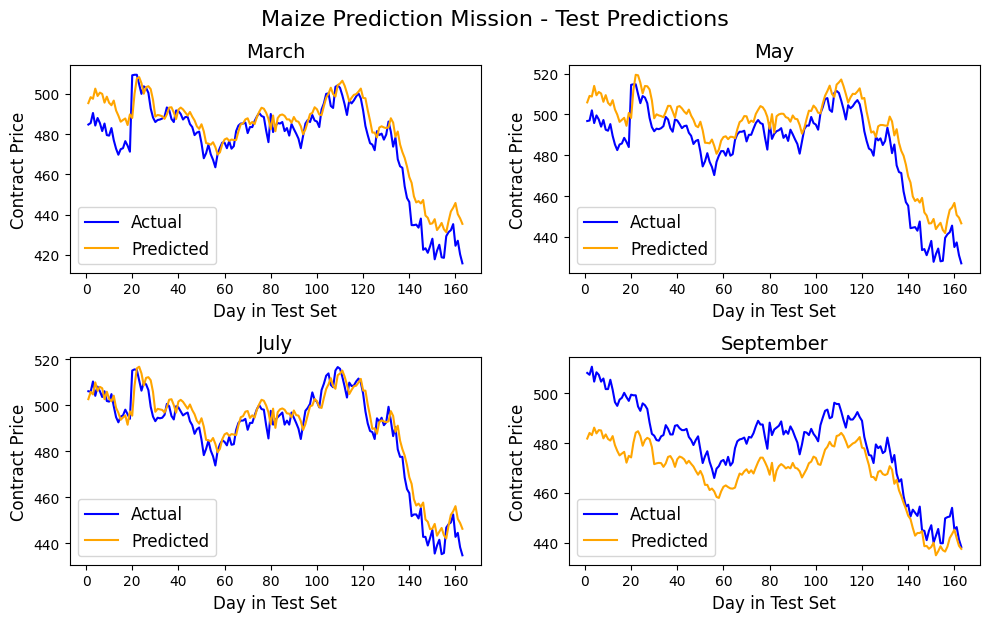

Maize Final Model Test RMSE: 9.7906



100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


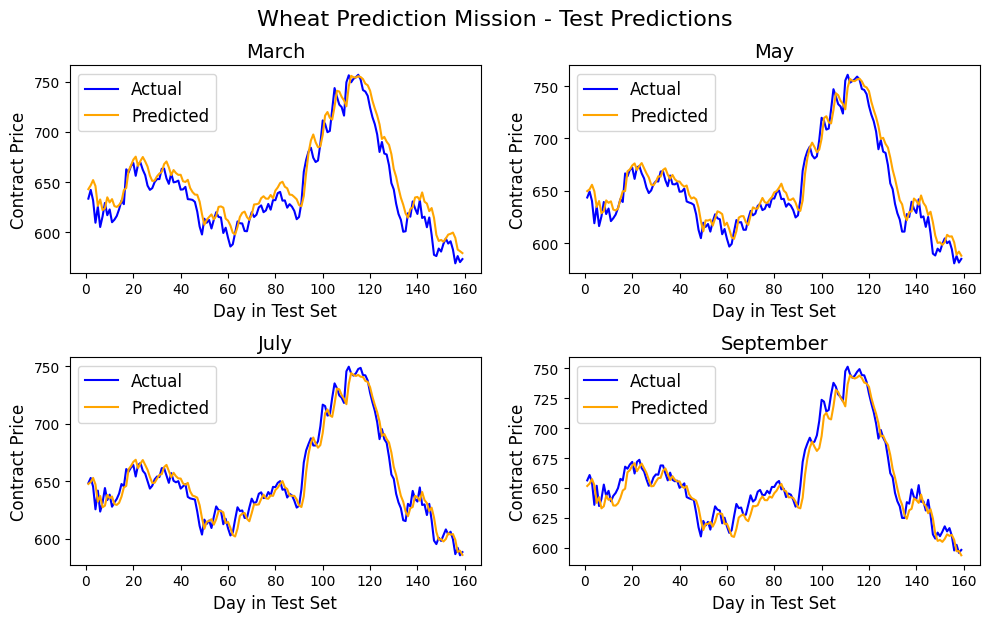

Wheat Final Model Test RMSE: 11.1321



100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


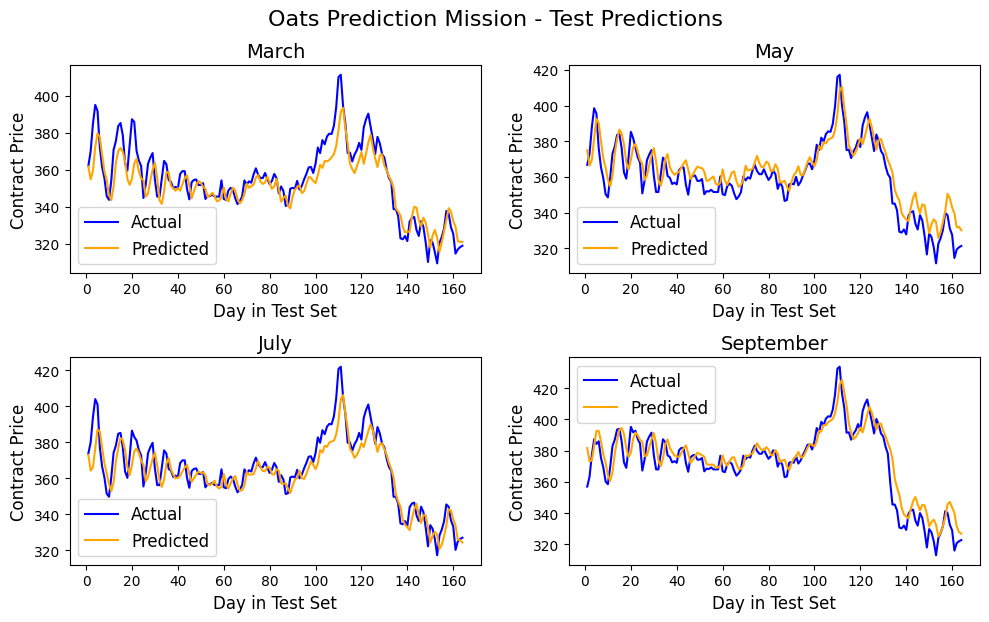

Oats Final Model Test RMSE: 8.9204



100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


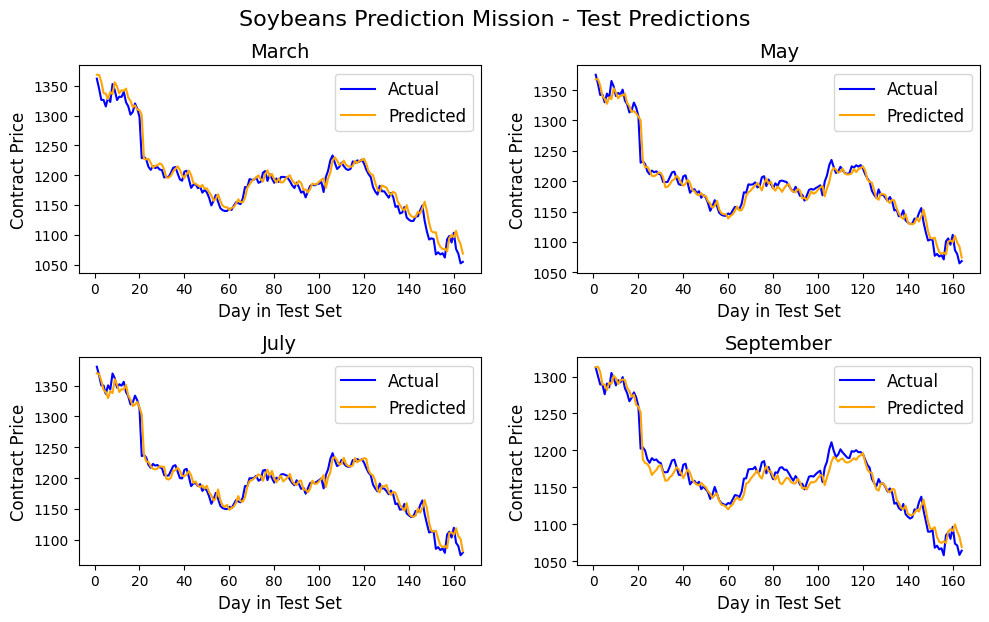

Soybeans Final Model Test RMSE: 12.0084


In [15]:
eval_sequential_model(model_name='LSTM', hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS, extra_fc_layers=LSTM_EXTRA_FC_LAYERS, 
                      lr=LR, num_epochs=NUM_EPOCHS)

Results summary - LSTM model:
| Model | Hidden Size | Num Layers | Extra FC Layers | Maize Test RMSE | Wheat Test RMSE | Oats Test RMSE | Soybeans Test RMSE | Average Test RMSE |
|-------|-------------|------------|----------------|-----------------|-----------------|----------------|---------------------|-------------------|
| LSTM  | 32          | 1          | 0              | 9.7906         | 11.1321         | 8.9204      | 12.0084            | 10.4629          |

When we compared the results of the two models, we found that the RNN model performed slightly better than the LSTM model, but with a smaller gap than in the validation set. Generally, it seems like the validation set was harder to predict than the test set, as the RMSE values in the test set are lower than in the validation set.

An important note is that none of the models was able to pass the performances of the AR time-series model, whice we evaluated in the 
ar.ipynb notebook. Notice that the AR model predcit only one contract and the Deep Learning models predict all the contracts at once, but the results are still comparable due to the built-in average in the RMSE calculation.

## Time Series Forecasting - Full Dataset Price Prediction 

Following that, we looked into the possibility to add past data of other commodities to the model, in addition to the past data of the commodity for which we are predicting the future. We used the same hyperparameters as before to keep the comparison fair.

In [16]:
def eval_sequential_model_for_all(model_name='RNN', hidden_size=8, num_layers=1, extra_fc_layers=0, lr=LR, num_epochs=NUM_EPOCHS):
    torch.manual_seed(0)
    train_loader_dataset, val_loader_dataset, test_loader_dataset, scaler = create_commodity_dataloaders('dataset')

    for i, commodity in enumerate(COMMODITIES):
        loc = COMMODITIES_LOCS[commodity]
        if model_name == 'RNN':
            model = RNNModel(input_size=18, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        elif model_name == 'LSTM':
            model = LSTMModel(input_size=18, hidden_size=hidden_size, num_layers=num_layers, extra_fc_layers=extra_fc_layers)
        else:
            print('Invalid model')
            return
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        _, _, best_model = train_model(model, train_loader_dataset, val_loader_dataset,
                                        criterion, optimizer, num_epochs=num_epochs, loc=loc)
        model.load_state_dict(best_model)
        
        fig, axes = plt.subplots(2, 2, figsize=(10, 6))
        axes = axes.flatten()
        model.eval()
        targets_lst = []
        outputs_lst = []
        with torch.no_grad():
            for inputs, targets in test_loader_dataset:
                inputs, targets = inputs.float(), targets.float()
                outputs = model(inputs)
                targets_lst.append(targets)
                outputs_lst.append(outputs)
        targets = torch.cat(targets_lst).numpy()
        outputs = torch.cat(outputs_lst).numpy()
        
        targets = scaler.inverse_transform(targets)[:, (loc-1)*4:loc*4]
        padded_outputs = np.zeros((outputs.shape[0], inputs.shape[2]))
        padded_outputs[:, (loc-1)*4:loc*4] = outputs
        outputs = scaler.inverse_transform(padded_outputs)[:, (loc-1)*4:loc*4]
        
        for j in range(4):
            contract_name = CONTRACTS[j]
            days = list(range(1, len(targets) + 1))
            axes[j].plot(days, targets[:, j], label='Actual', color='blue')
            axes[j].plot(days, outputs[:, j], label='Predicted', color='orange')
            axes[j].set_title(f'{contract_name}', fontsize=14)
            axes[j].set_xlabel('Day in Test Set', fontsize=12)
            axes[j].set_ylabel('Contract Price', fontsize=12)
            axes[j].legend(fontsize=12)
            
        plt.tight_layout(h_pad=1.0, w_pad=2.0)
        fig.suptitle(f'{commodity} Prediction Mission with Full Dataset - Test Predictions', fontsize=16, y=1.03)
        plt.show()
        
        _, rmse = test_model(model, test_loader_dataset, criterion, scaler=scaler, loc=loc, calc_rmse=True)
        print(f'{commodity} Prediction with Full Dataset, Final Model Test RMSE: {rmse:.4f}')
        if i < len(COMMODITIES) - 1:
            print()

100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


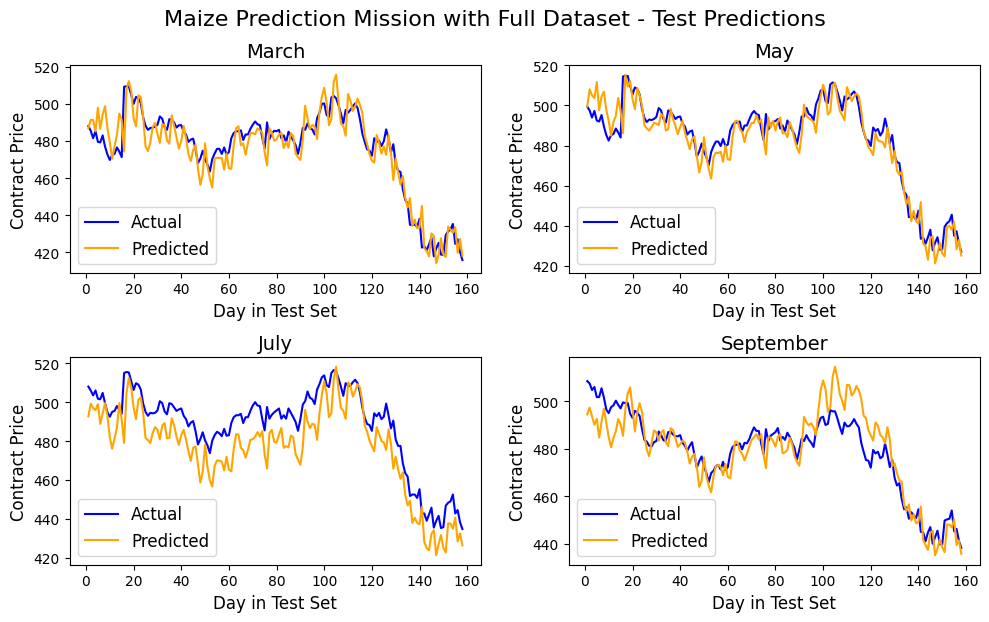

Maize Prediction with Full Dataset, Final Model Test RMSE: 9.3743



100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


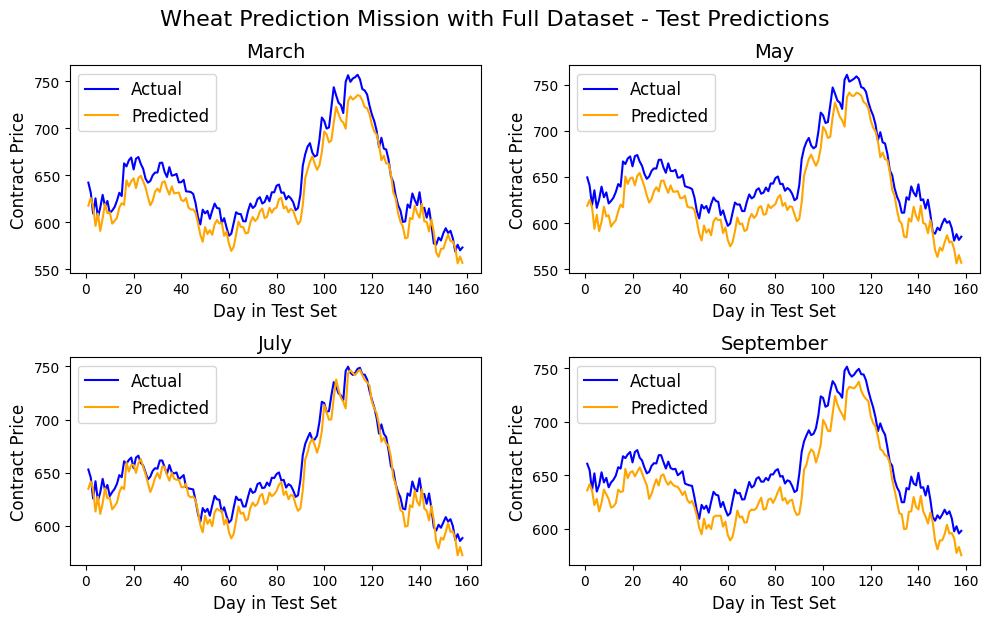

Wheat Prediction with Full Dataset, Final Model Test RMSE: 18.8447



100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


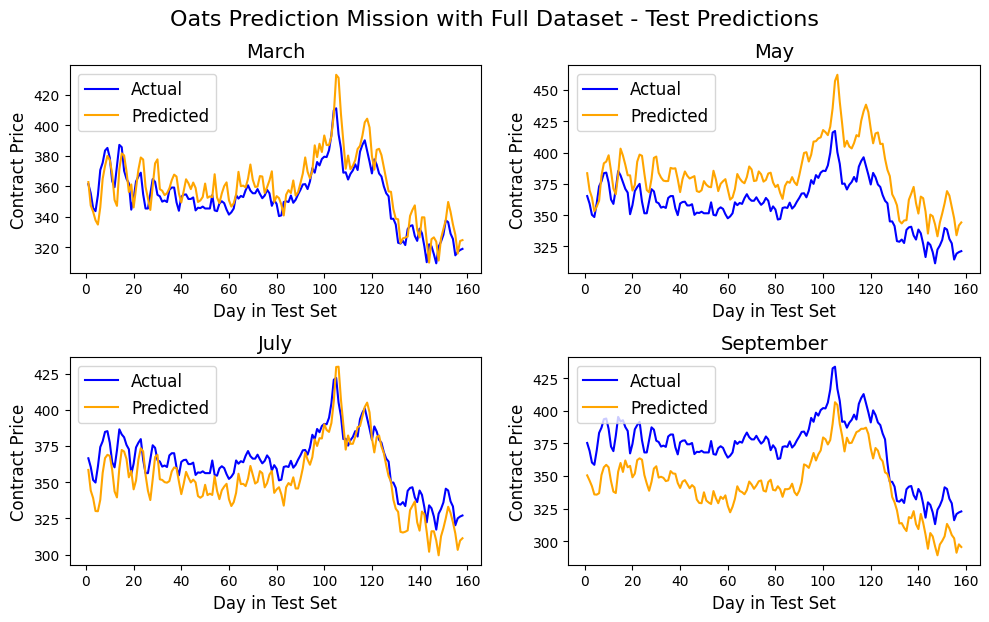

Oats Prediction with Full Dataset, Final Model Test RMSE: 20.3159



100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


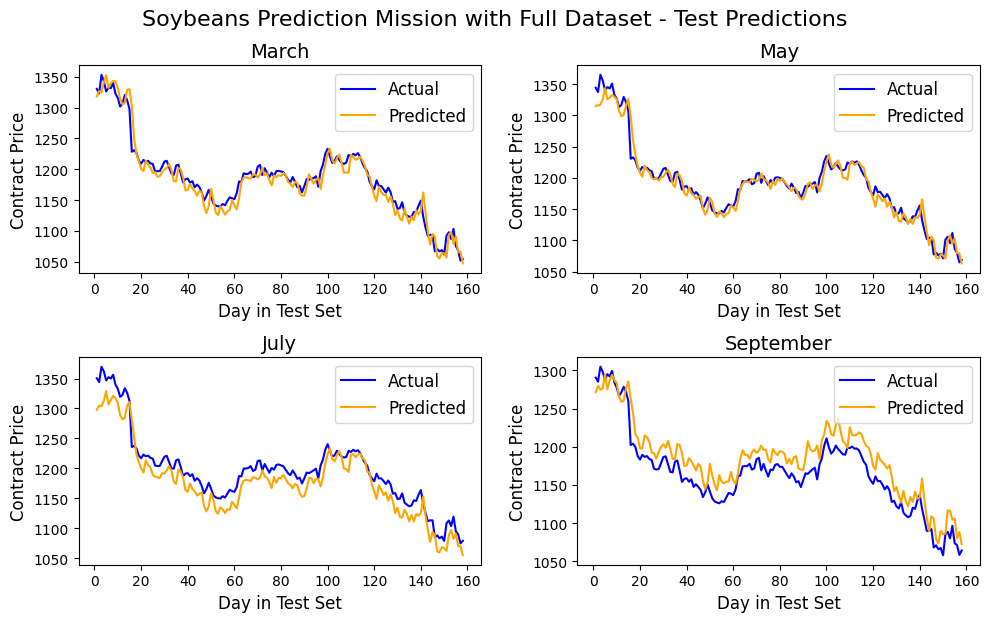

Soybeans Prediction with Full Dataset, Final Model Test RMSE: 18.9138


In [17]:
eval_sequential_model_for_all(model_name='RNN', hidden_size=RNN_HIDDEN_SIZE, num_layers=RNN_NUM_LAYERS, extra_fc_layers=RNN_EXTRA_FC_LAYERS,
                              lr=LR, num_epochs=NUM_EPOCHS)

Results summary - RNN model:
| Model | Hidden Size | Num Layers | Extra FC Layers | Maize Test RMSE | Wheat Test RMSE | Oats Test RMSE | Soybeans Test RMSE | Average Test RMSE |
|-------|-------------|------------|----------------|-----------------|-----------------|----------------|---------------------|-------------------|
| RNN   | 16          | 1          | 0              | 9.3743         | 18.8447         | 20.3159        | 18.9138           | 16.8622          |

100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


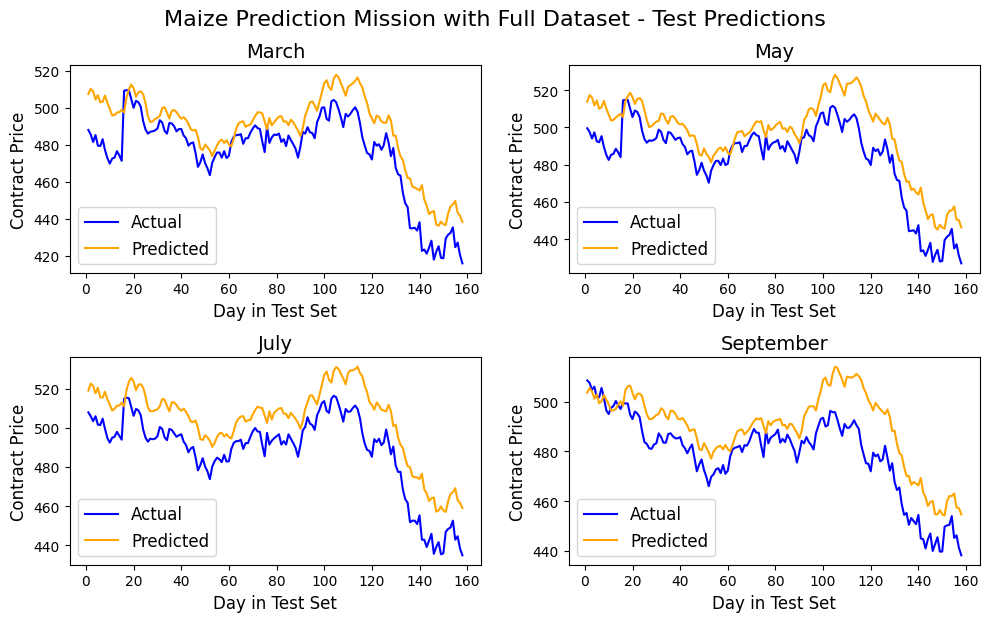

Maize Prediction with Full Dataset, Final Model Test RMSE: 15.1013



100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


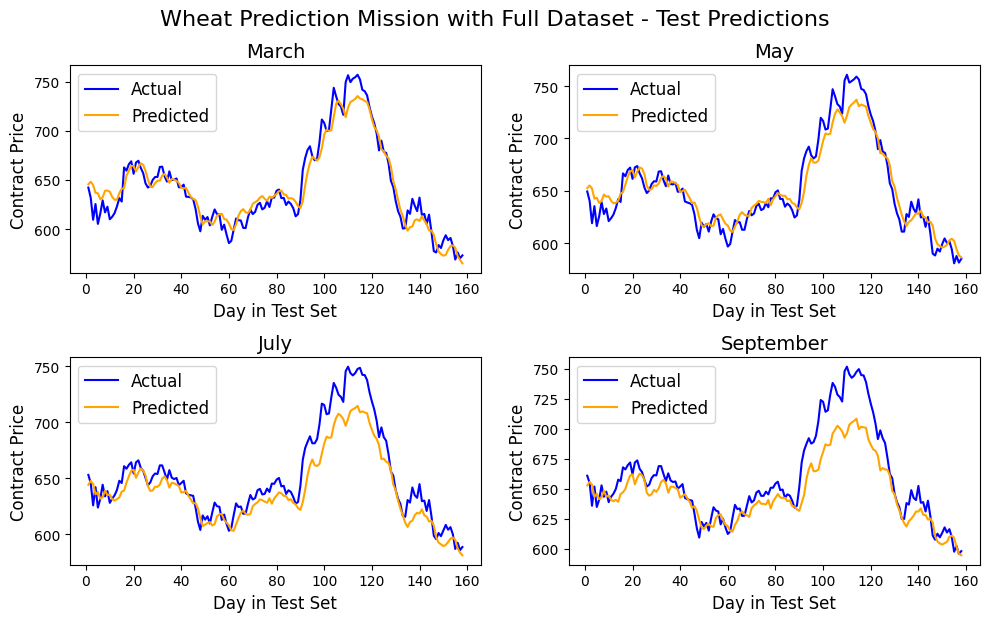

Wheat Prediction with Full Dataset, Final Model Test RMSE: 15.5003



100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


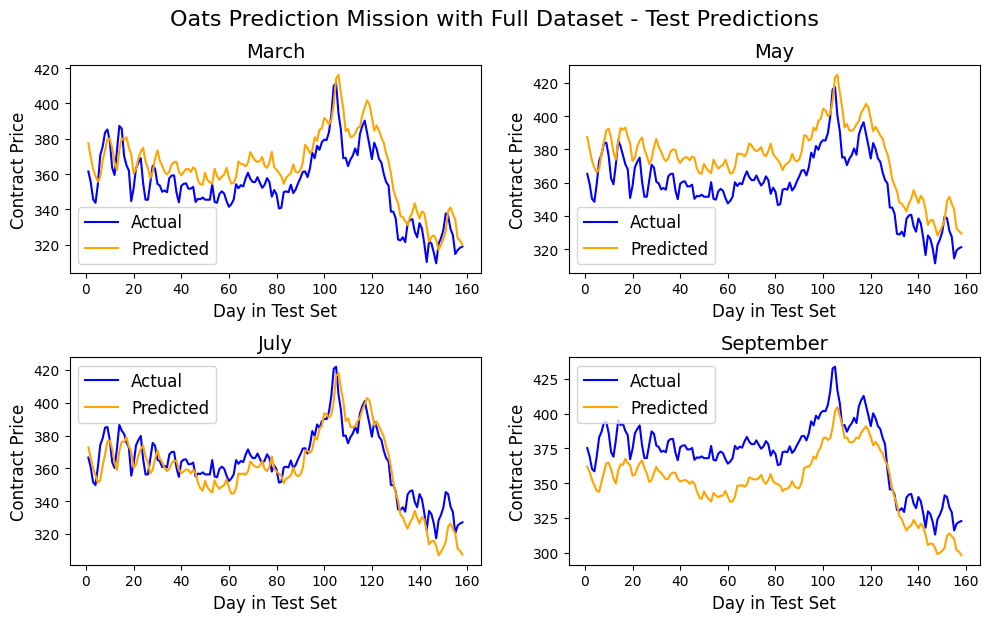

Oats Prediction with Full Dataset, Final Model Test RMSE: 15.8290



100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


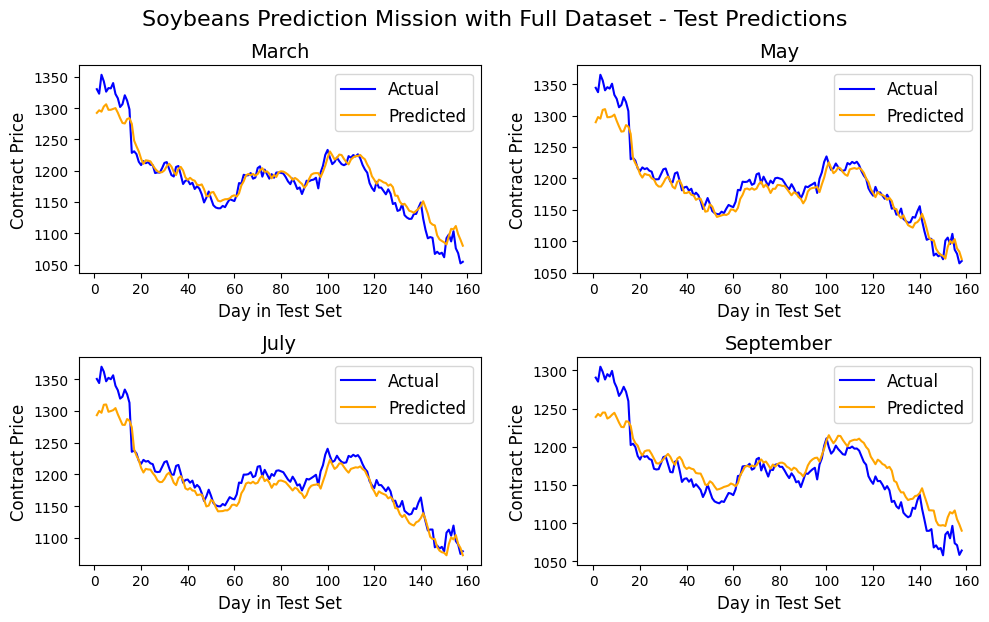

Soybeans Prediction with Full Dataset, Final Model Test RMSE: 19.7902


In [18]:
eval_sequential_model_for_all(model_name='LSTM', hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS, extra_fc_layers=LSTM_EXTRA_FC_LAYERS, 
                              lr=LR, num_epochs=NUM_EPOCHS)

Results summary - LSTM model:
| Model | Hidden Size | Num Layers | Extra FC Layers | Maize Test RMSE | Wheat Test RMSE | Oats Test RMSE | Soybeans Test RMSE | Average Test RMSE |
|-------|-------------|------------|----------------|-----------------|-----------------|----------------|---------------------|-------------------|
| LSTM  | 32          | 1          | 0              | 15.1013        | 15.5003        | 15.8290      | 19.7902            | 16.5552          |

It can be seen that the inclusion of past data of other commodities did not improve the model's performance, and in fact, it made it significantly worse. Although we already saw in the regression task that there is a correlation between the commodities, it seems that this correlation is not strong enough to help the model predict the future prices of a commodity based on the past prices of other commodities, and that the inclusion of this data only adds noise to the model and increases the chance of overfitting.

## Conclusion

In conclusion, the RNN model is found superior to the LSTM model when using single commodity data, and the LSTM model is found superior to the RNN model when using multiple commodity data. However, none of them is as good as the AR time-series model. We believe that the advantage of the sequential deep learning models is manifested when we need to combine knowledge time series of large complex vectors with complex patterns, but in the case of simple time series with strong linear patterns, as in our case, the AR model is more suitable.